In [1]:
import cobra.test
import cobra.io
from cobra.sampling import sample
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

In [5]:
#cobra.io.validate_sbml_model("iAT601.xml")
#cobra.io.validate_sbml_model("cellulose.xml")
# UserWarning: malformed gene_reaction_rule 'Clo1313_1355; Clo1313_1353; Clo1313_1356' for <Reaction R01197_c at 0x7f8ca7c5a250>
# UserWarning: malformed gene_reaction_rule 'Clo1313_2018; Clo1313_2017' for <Reaction R03660_c at 0x7f8ca7a0e8d0>
# changed in cellulose_revised.xml
cellulose=cobra.io.read_sbml_model("cellulose_repaired.xml")

Removing parenthesis from gpr ( Clo1313_1355; or Clo1313_1353; or Clo1313_1356 ) leads to an error, so keeping parenthesis
cobra/core/reaction.py:446 UserWarning: malformed gene_reaction_rule '( Clo1313_1355; or Clo1313_1353; or Clo1313_1356 )' for <Reaction R01197_c at 0x7fcf88c5ab90>
Removing parenthesis from gpr ( Clo1313_2018; or Clo1313_2017 ) leads to an error, so keeping parenthesis
cobra/core/reaction.py:446 UserWarning: malformed gene_reaction_rule '( Clo1313_2018; or Clo1313_2017 )' for <Reaction R03660_c at 0x7fcf88a6cd10>


In [10]:
cellulose.medium
# output exchage reaction in medium
for i in cellulose.reactions:
    id=i.id
    if id.startswith("EXC_"):
        print(id)

EXC_IN_m20
EXC_IN_m17
EXC_IN_m21
EXC_IN_m22
EXC_IN_m23
EXC_IN_m24
EXC_IN_m25
EXC_IN_m26
EXC_IN_m27
EXC_IN_m28
EXC_IN_m29
EXC_IN_m30
EXC_IN_m97
EXC_IN_m98
EXC_IN_m99
EXC_IN_m100
EXC_IN_m101
EXC_OUT_m51
EXC_OUT_m52
EXC_OUT_m53
EXC_OUT_m54
EXC_OUT_m55
EXC_OUT_m56
EXC_OUT_m57
EXC_OUT_m86
EXC_OUT_m90
EXC_OUT_m103
EXC_OUT_m105
EXC_OUT_m106
EXC_OUT_m107
EXC_OUT_m108
EXC_OUT_m109
EXC_OUT_m110
EXC_OUT_m111
EXC_OUT_m112
EXC_BOTH_m18
EXC_BOTH_m19
EXC_BOTH_m31
EXC_BOTH_m32
EXC_BOTH_m33
EXC_BOTH_m34
EXC_BOTH_m35
EXC_BOTH_m36
EXC_BOTH_m37
EXC_BOTH_m38
EXC_BOTH_m39
EXC_BOTH_m40
EXC_BOTH_m41
EXC_BOTH_m42
EXC_BOTH_m43
EXC_BOTH_m44
EXC_BOTH_m45
EXC_BOTH_m46
EXC_BOTH_m47
EXC_BOTH_m48
EXC_BOTH_m49
EXC_BOTH_m50


In [6]:
solution=cellulose.optimize()
cellulose.summary(solution=solution,threshold=0.00001)

In [48]:
df=cellulose.summary(solution=solution,threshold=0.00001).to_frame()
id=list(df.IN_FLUXES.ID)+list(df.OUT_FLUXES.ID)
for i in id[:-1]:
    print(i,cellulose.metabolites.get_by_id(i).name)

m18[C_e] H2O_H2O
m21[C_e] Urea_CH4N2O
m97[C_e] Cellohexaose
m26[C_e] Orthophosphate_H3O4P
m35[C_e] L-Cysteine_C3H7NO2S
m24[C_e] K+_
m23[C_e] Mg2+_
m30[C_e] Nicotinate D-ribonucleotide_C11H14NO9P
m27[C_e] Fe3+_Fe
m22[C_e] Ca2+_
m55[C_e] Hydrogen_H2
m19[C_e] CO2_CO2
m52[C_e] Acetate_C2H4O2
m51[C_e] Ethanol_C2H6O
m110[C_e] Fumarate_C4H4O4
m53[C_e] Formate_CH2O2
m86[C_e] Biomass_
m57[C_e] Succinate_C4H6O4
m43[C_e] L-Methionine_C5H11NO2S


In [77]:
# add constrain
@np.vectorize
def add_constrain(h2,c2h6o):
    with cellulose as test:
        test.reactions.EXC_OUT_m55.lower_bound=h2
        test.reactions.EXC_OUT_m55.upper_bound=h2
        test.reactions.EXC_OUT_m51.lower_bound=c2h6o
        test.reactions.EXC_OUT_m51.upper_bound=c2h6o
        a=test.slim_optimize()
        if np.isnan(a):
            a=0
        return(a)

In [85]:
x, y = np.mgrid[0:16:100j, 0:6:100j]  
z = add_constrain(x, y)

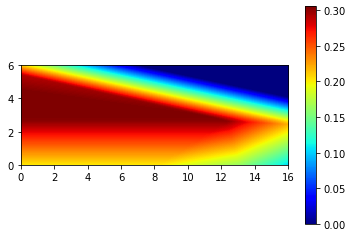

In [90]:
plt.imshow(z, extent=[0, 16, 0, 6], cmap=pl.cm.jet, origin="lower") 
plt.colorbar()

In [3]:
# flux sample
# https://cobrapy.readthedocs.io/en/latest/sampling.html?highlight=sample
co = cellulose.problem.Constraint(cellulose.reactions.R_BIO.flux_expression, lb=0.305473,ub=0.305473)
cellulose.add_cons_vars([co])
s = sample(cellulose, 10)
exc=s.loc[:,['EXC_OUT_m55','EXC_OUT_m51','EXC_OUT_m52','EXC_OUT_m53','R_BIO']]
exc.columns=["H2","C2H6O","C2H4O2","CH2O2","Biomass"]
exc

,H2,C2H6O,C2H4O2,CH2O2,Biomass
0,8.879756,2.629363,3.549999,1.390000,0.305473
1,8.601943,2.631262,3.549997,1.390000,0.305473
2,8.606090,2.625336,3.549997,1.389999,0.305473
3,8.872785,2.644244,3.549999,1.389999,0.305473
4,8.957054,2.642566,3.550000,1.389999,0.305473
5,8.318807,2.629481,3.549996,1.389999,0.305473
6,8.868686,2.641969,3.549999,1.389999,0.305473
7,8.562167,2.629153,3.549999,1.390000,0.305473
8,8.769960,2.638255,3.549998,1.390000,0.305473
9,8.862651,2.612038,3.549998,1.390000,0.305473


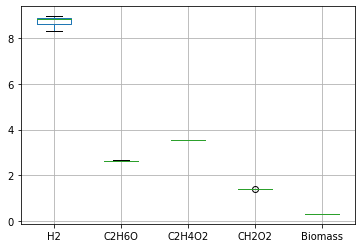

In [4]:
exc.boxplot()
plt.show()